In [ ]:
import numpy as np 
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
sns.set(rc={'figure.figsize':(15,5)})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive

/content/drive


In [ ]:
ls

MyDrive/  Shareddrives/


In [ ]:
cd My Drive/RES

/content/drive/My Drive/RES


In [ ]:
ls

LSTM.ipynb  T1.csv


In [ ]:
data = pd.read_csv("T1.csv")
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [ ]:
data['Date/Time'] = pd.to_datetime(data['Date/Time']).dt.normalize()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date/Time                      50530 non-null  datetime64[ns]
 1   LV ActivePower (kW)            50530 non-null  float64       
 2   Wind Speed (m/s)               50530 non-null  float64       
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64       
 4   Wind Direction (°)             50530 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB


In [ ]:
data1 = data[["Date/Time", "Wind Speed (m/s)"]]
data1.head()

,Date/Time,Wind Speed (m/s)
0,2018-01-01,5.311336
1,2018-01-01,5.672167
2,2018-01-01,5.216037
3,2018-01-01,5.659674
4,2018-01-01,5.577941


In [ ]:
data1["Wind Speed (m/s)"].mean()

7.557952236083194

In [ ]:
data2 = data1.groupby(by=["Date/Time"], as_index=False)["Wind Speed (m/s)"].mean()

print("min date: ", data2["Date/Time"].min())
print("max date: ", data2["Date/Time"].max())

data2.head()

min date:  2018-01-01 00:00:00
max date:  2018-12-31 00:00:00


,Date/Time,Wind Speed (m/s)
0,2018-01-01,8.022975
1,2018-01-02,14.954779
2,2018-01-03,6.628723
3,2018-01-04,15.665819
4,2018-01-05,3.059440


In [ ]:
data2.index = data2.pop('Date/Time')
data2.head()

,Wind Speed (m/s)
Date/Time,
2018-01-01,8.022975
2018-01-02,14.954779
2018-01-03,6.628723
2018-01-04,15.665819
2018-01-05,3.059440


Text(0.5, 1.0, 'LV ActivePower (kW)')

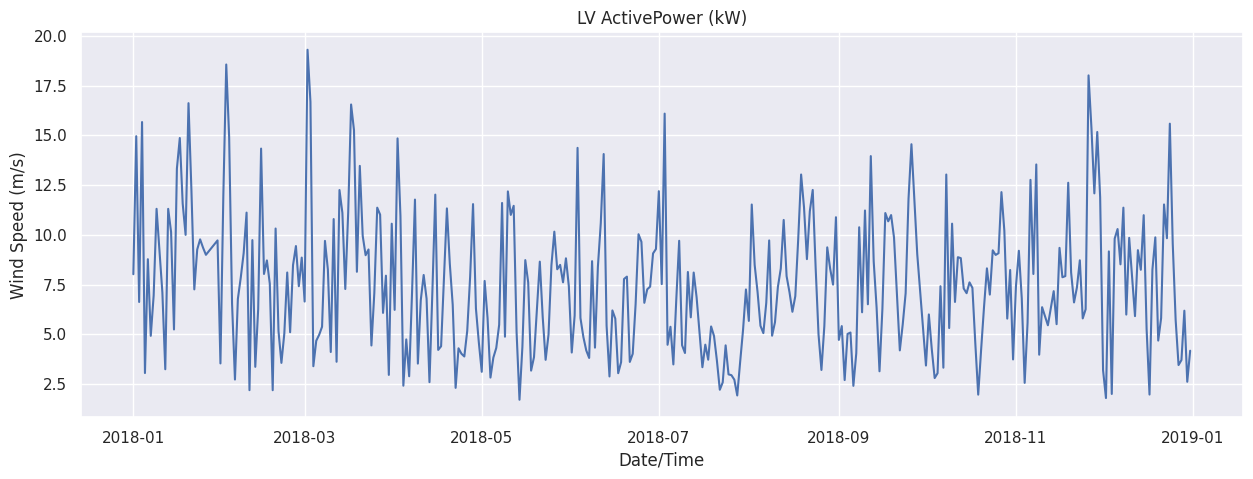

In [ ]:
sns.lineplot(data=data2, x=data2.index, y="Wind Speed (m/s)").set_title("LV ActivePower (kW)")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data2)

data2["Wind Speed (m/s) scaled"] = scaled_data

In [ ]:
rango = 30

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
  first_date =  pd.to_datetime(first_date_str)
  last_date  =  pd.to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Wind Speed (m/s) scaled'].to_numpy()
    x, y = values[:-1], values[-1]
 
    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(data2, '2018-02-05', '2018-12-31', rango)
windowed_df.head()

,Target Date,Target-30,Target-29,Target-28,Target-27,Target-26,Target-25,Target-24,Target-23,Target-22,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2018-02-05,0.752995,0.279344,0.793444,0.076296,0.401523,0.182626,0.297977,0.545525,0.306336,...,0.458228,0.434630,0.414085,0.455282,0.103770,0.584935,0.957845,0.750226,0.274877,0.057748
1,2018-02-06,0.279344,0.793444,0.076296,0.401523,0.182626,0.297977,0.545525,0.306336,0.087126,...,0.434630,0.414085,0.455282,0.103770,0.584935,0.957845,0.750226,0.274877,0.057748,0.287954
2,2018-02-07,0.793444,0.076296,0.401523,0.182626,0.297977,0.545525,0.306336,0.087126,0.545441,...,0.414085,0.455282,0.103770,0.584935,0.957845,0.750226,0.274877,0.057748,0.287954,0.349164
3,2018-02-08,0.076296,0.401523,0.182626,0.297977,0.545525,0.306336,0.087126,0.545441,0.479280,...,0.455282,0.103770,0.584935,0.957845,0.750226,0.274877,0.057748,0.287954,0.349164,0.418997
4,2018-02-09,0.401523,0.182626,0.297977,0.545525,0.306336,0.087126,0.545441,0.479280,0.200849,...,0.103770,0.584935,0.957845,0.750226,0.274877,0.057748,0.287954,0.349164,0.418997,0.534709


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((325,), (325, 30, 1), (325,))

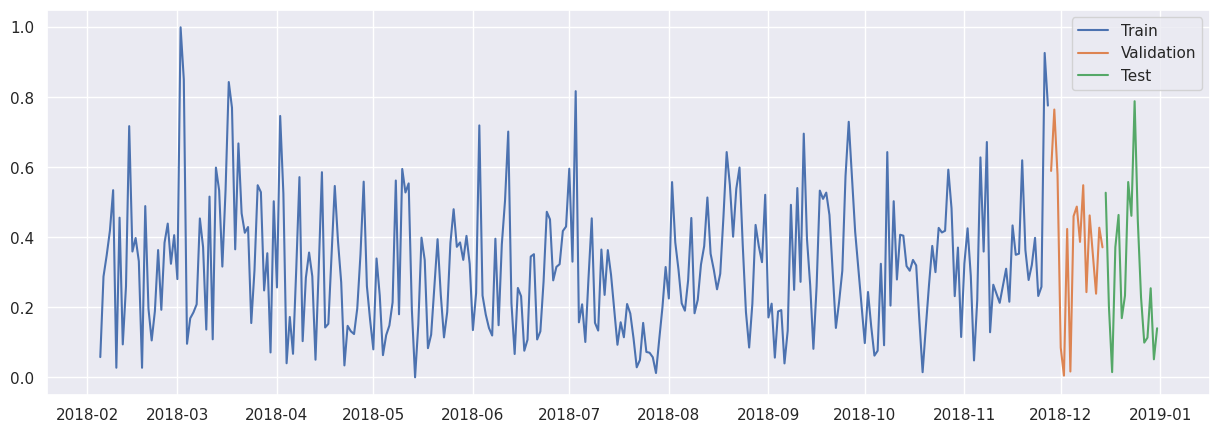

In [ ]:
q_80 = int(len(dates) * .90)
q_90 = int(len(dates) * .95)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(InputLayer((rango, 1)))
model.add(Bidirectional(LSTM(rango, return_sequences=True)))
model.add(Bidirectional(LSTM(rango, return_sequences=False)))
model.add(Dense(25))
model.add(Dense(1))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 60)           7680      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               21840     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 25)                1525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,071
Trainable params: 31,071
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500)

Epoch 1/500
10/10 [==============================] - 12s 309ms/step - loss: 0.0995 - root_mean_squared_error: 0.3155 - val_loss: 0.1079 - val_root_mean_squared_error: 0.3285
Epoch 2/500
10/10 [==============================] - 1s 93ms/step - loss: 0.0683 - root_mean_squared_error: 0.2613 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2707
Epoch 3/500
10/10 [==============================] - 1s 93ms/step - loss: 0.0476 - root_mean_squared_error: 0.2181 - val_loss: 0.0526 - val_root_mean_squared_error: 0.2294
Epoch 4/500
10/10 [==============================] - 1s 96ms/step - loss: 0.0368 - root_mean_squared_error: 0.1919 - val_loss: 0.0452 - val_root_mean_squared_error: 0.2126
Epoch 5/500
10/10 [==============================] - 1s 55ms/step - loss: 0.0352 - root_mean_squared_error: 0.1875 - val_loss: 0.0445 - val_root_mean_squared_error: 0.2110
Epoch 6/500
10/10 [==============================] - 1s 50ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880 - val_loss: 0.0444 - va

10/10 [==============================] - 2s 13ms/step


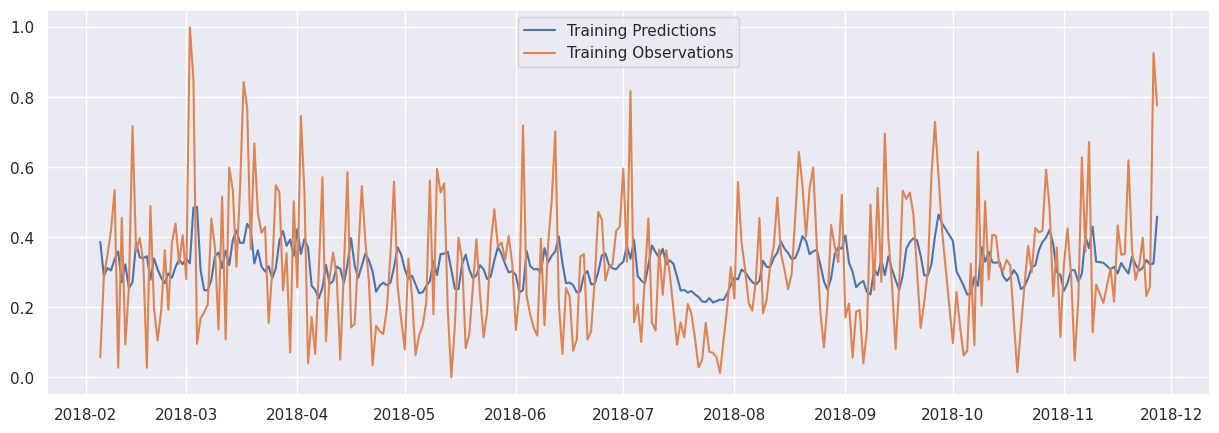

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 35ms/step


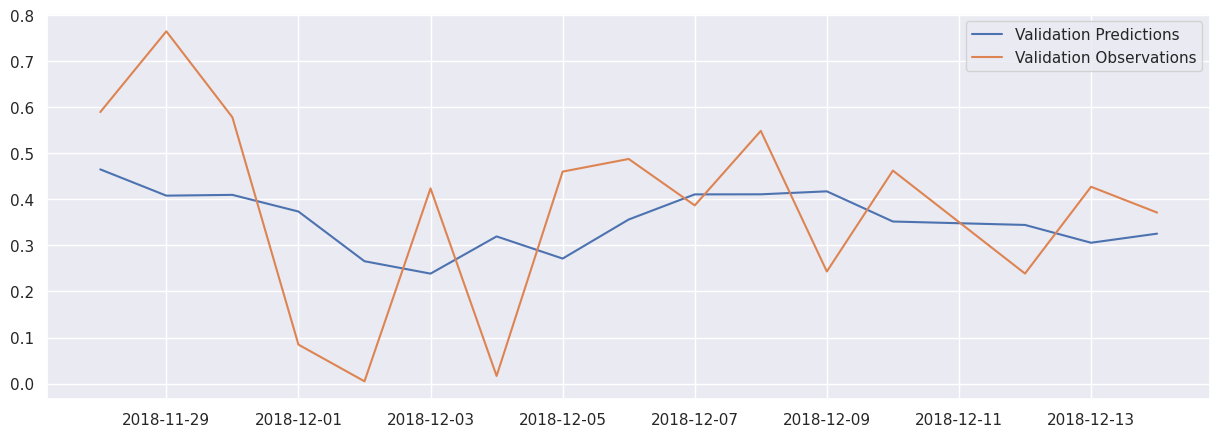

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 49ms/step


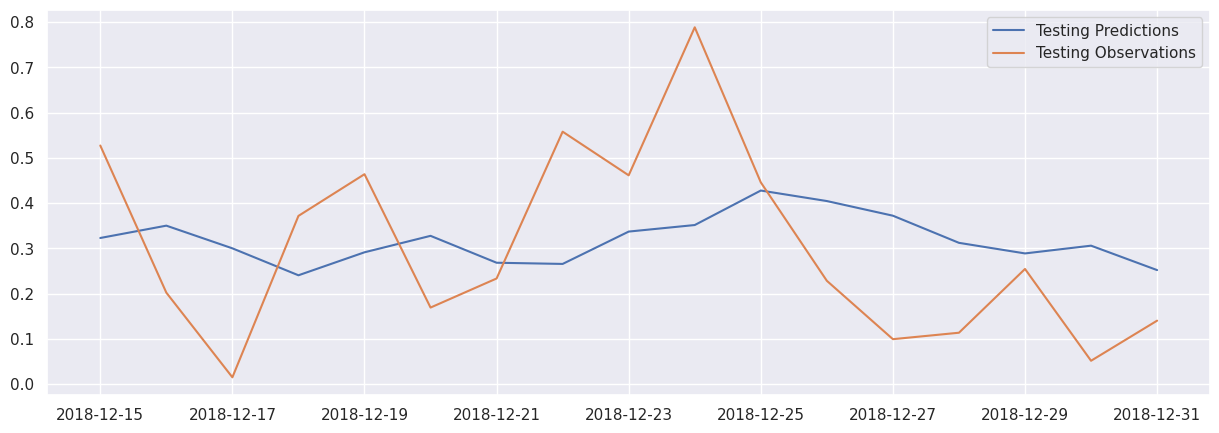

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

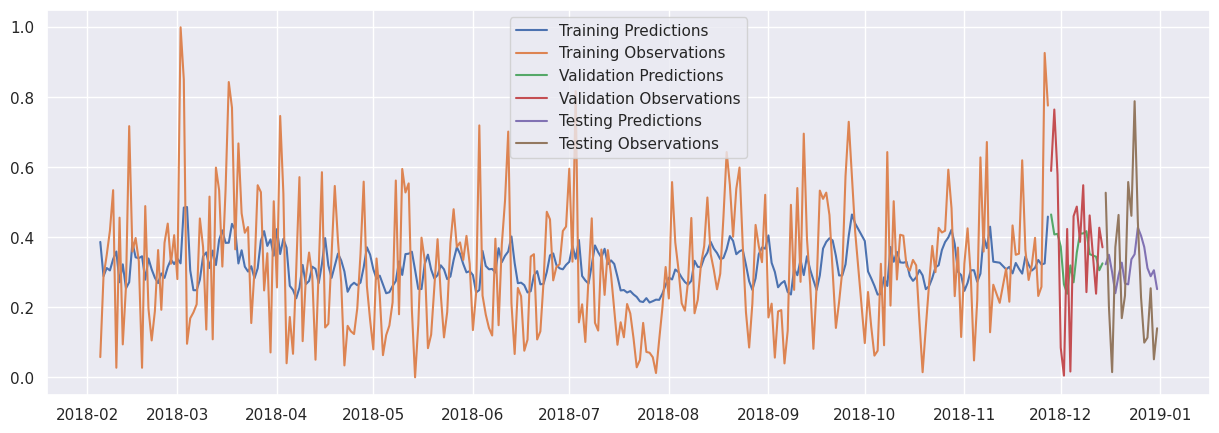

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

XT = X_train.copy()

last_window = deepcopy(XT[-1])
for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window = np.append(last_window, next_prediction)
    last_window = last_window[1:].reshape(rango,1)

1/1 [==============================] - 0s 30ms/step


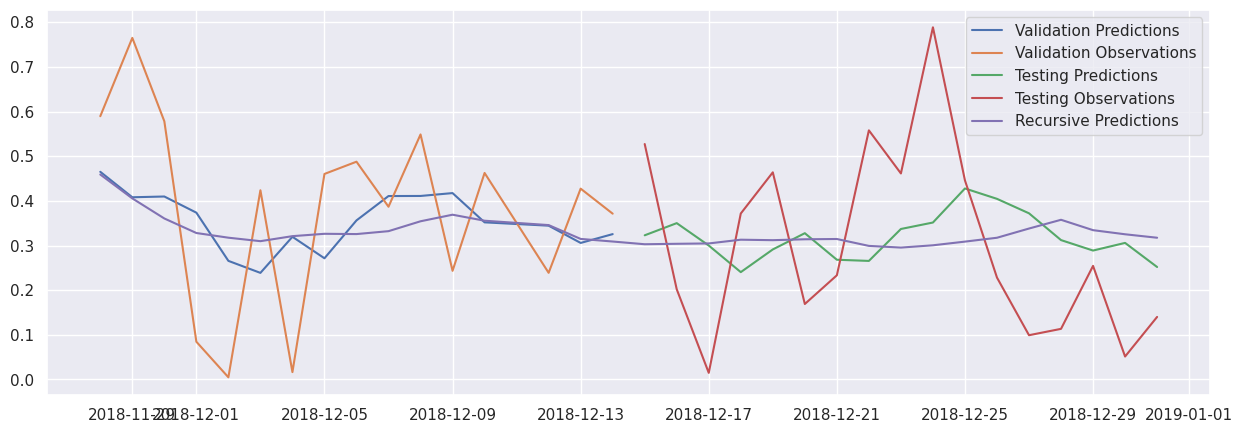

In [ ]:
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend([
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])